# TP DEBANDI

## Análisis de los datos

Este notebook es la continuación de la notebook de carga de datos que pre-proceso los datos de casos de Covid entre enero 2020 y mayo 2021, sumándole la información sobre origen de nacimiento (1-creacion-dataset-parquet)

Para optimizar los tiempos de procesamiento y dado el volumen da datos se realizó el trabajo sobre una muestra del 10% (ver la notebook de carga)

Son 474.572 casos confirmados que incluyen las siguientes variables:

id_evento_caso: integer (nullable = true)
sexo: string (nullable = true)
edad: integer (nullable = true)
fecha_inicio_sintomas: date (nullable = true)
fecha_apertura: date (nullable = true)
sepi_apertura: integer (nullable = true)
origen_financiamiento: string (nullable = true)
residencia_provincia_id: string (nullable = true)
residencia_departamento_id: integer (nullable = true)
fecha_internacion: date (nullable = true)
cuidado_intensivo: string (nullable = true)
fallecido: string (nullable = true)
pais_nacimiento: string (nullable = true)

El objetivo es realizar un análisis exploratorio de los datos inicial y luego aplicar dos técnicas de clasificación binaria: regresión logística y árboles de clasificación para intentar predecir la valiable fallecido a partir de las variabvle sexistentes y los features.

Es importante ACLARAR que se trata de un ejercicio con fines de diseñar lo que podría ser un experimento como este. Las variables con las que se cuenta no son suficientes para poder explicar el fallecimiento por COVID.

Como se verá en los resultados, si bien los modelos parecen aprender correctamente los grupos (fallecidos vs no fallecidos) estan muy desbalanceados por lo que el éxito de los modelos es porque se clasifica la mayor parte como no fallecidos. 

No se realiz


In [1]:
import findspark
findspark.init()

In [2]:
from pyspark.sql import SparkSession
spark = (
    SparkSession.builder
    .appName("pyspark-intro")
    .config("spark.driver.memory", "512m")
    .config("spark.driver.cores", "1")
    .config("spark.executor.memory", "512m")
    .config("spark.executor.cores", "1")
    .config("spark.sql.shuffle.partitions", "2")
    .getOrCreate()
)

Se leen los datos desde el archivo parquet creado en la notebook previa.

In [3]:
#dfTemp2.write.parquet("/dataset/parquet-confirmados-muestra/covid-muestra.parquet") 
dfcovid=spark.read.parquet("/dataset/parquetv3/covidmigrantes.parquet") 



In [4]:
dfcovid.show(5)

+--------------+----+----+---------------------+-------------------+-------------------+-------------+---------------------+-----------------------+--------------------------+-------------------+-----------------+---------+---------------+
|id_evento_caso|sexo|edad|fecha_inicio_sintomas|     fecha_apertura|  fecha_diagnostico|sepi_apertura|origen_financiamiento|residencia_provincia_id|residencia_departamento_id|  fecha_internacion|cuidado_intensivo|fallecido|pais_nacimiento|
+--------------+----+----+---------------------+-------------------+-------------------+-------------+---------------------+-----------------------+--------------------------+-------------------+-----------------+---------+---------------+
|        740861|   F|  75|  2020-03-02 00:00:00|2020-03-07 00:00:00|2020-03-09 00:00:00|           10|              Público|                     22|                       140|               null|               NO|       NO|      Argentina|
|        744751|   M|  67|  2020-03-08 0

In [5]:
dfcovid.count()

474572

In [6]:
dfcovid.printSchema()

root
 |-- id_evento_caso: integer (nullable = true)
 |-- sexo: string (nullable = true)
 |-- edad: integer (nullable = true)
 |-- fecha_inicio_sintomas: timestamp (nullable = true)
 |-- fecha_apertura: timestamp (nullable = true)
 |-- fecha_diagnostico: timestamp (nullable = true)
 |-- sepi_apertura: integer (nullable = true)
 |-- origen_financiamiento: string (nullable = true)
 |-- residencia_provincia_id: integer (nullable = true)
 |-- residencia_departamento_id: integer (nullable = true)
 |-- fecha_internacion: timestamp (nullable = true)
 |-- cuidado_intensivo: string (nullable = true)
 |-- fallecido: string (nullable = true)
 |-- pais_nacimiento: string (nullable = true)



Se verifican que hay 474.572 casos

## Análisis exploratorio de los datos y creación de features

Se analiza la distribucion de cada variable para diseñar los features

In [7]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql import functions as F


### sexo

In [8]:
dfcovid.groupBy('sexo').count().orderBy('count').show()

+----+------+
|sexo| count|
+----+------+
|  NR|  4097|
|   M|233482|
|   F|236993|
+----+------+



In [9]:
dfcovid=dfcovid.withColumn("genero", 
    F.when((F.col("sexo") == 'NR'), None)\
    .when((F.col("sexo") == 'M'), 0)\
    .when((F.col("sexo") == 'F'), 1)\
    .otherwise(0)
)

dfcovid.groupBy('genero').count().orderBy('count').show()

+------+------+
|genero| count|
+------+------+
|  null|  4097|
|     0|233482|
|     1|236993|
+------+------+



### edad

In [10]:
dfcovid.groupBy('edad').count().orderBy('count').show()

+----+-----+
|edad|count|
+----+-----+
| 120|    1|
| 221|    1|
| 106|    1|
|   0|    2|
| 105|    4|
| 103|   11|
| 102|   16|
| 121|   22|
| 101|   26|
| 100|   36|
|  99|   57|
|  98|   81|
|  97|  103|
|null|  113|
|  96|  137|
|  95|  192|
|  94|  245|
|  93|  298|
|  92|  410|
|  91|  420|
+----+-----+
only showing top 20 rows



In [11]:
#pip install -U seaborn

In [12]:
#pip install -U scikit-learn

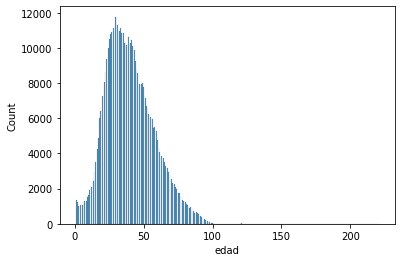

In [13]:

#grafico un histograma con la edad
sns.histplot(x="edad", data=dfcovid.toPandas())
plt.show()

La variable edad no se modifica, se mantiene como esta



### Analisis de las fechas

In [14]:
# |-- fecha_inicio_sintomas: timestamp (nullable = true)
# |-- fecha_apertura: timestamp (nullable = true)
# |-- fecha_diagnostico: timestamp (nullable = true)

### fecha apertura

In [15]:
dfcovid.createOrReplaceTempView("dfcovid")

dfTemp2= spark.sql("""
    Select fecha_apertura AS fecha, count(*) AS casos
    FROM dfcovid
    GROUP BY fecha_apertura
    ORDER BY fecha_apertura asc
    """)
dfTemp2.show()

+-------------------+-----+
|              fecha|casos|
+-------------------+-----+
|2020-03-07 00:00:00|    1|
|2020-03-10 00:00:00|    1|
|2020-03-12 00:00:00|    1|
|2020-03-13 00:00:00|    3|
|2020-03-15 00:00:00|    2|
|2020-03-16 00:00:00|    1|
|2020-03-17 00:00:00|    8|
|2020-03-18 00:00:00|    6|
|2020-03-19 00:00:00|    6|
|2020-03-20 00:00:00|    7|
|2020-03-21 00:00:00|    5|
|2020-03-22 00:00:00|    4|
|2020-03-23 00:00:00|    7|
|2020-03-24 00:00:00|   12|
|2020-03-25 00:00:00|   11|
|2020-03-26 00:00:00|   15|
|2020-03-27 00:00:00|   11|
|2020-03-28 00:00:00|    8|
|2020-03-29 00:00:00|   14|
|2020-03-30 00:00:00|   12|
+-------------------+-----+
only showing top 20 rows



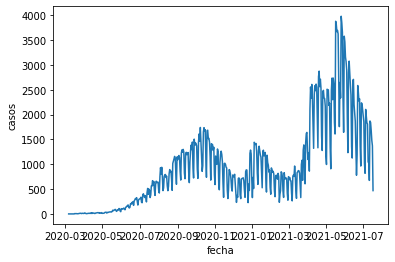

In [16]:
sns.lineplot(x="fecha", y="casos", data=dfTemp2.toPandas())
plt.show()

In [17]:
dfcovid.createOrReplaceTempView("dfcovid")

dfTemp2= spark.sql("""
    Select fecha_apertura AS fecha, count(*) AS fallecidos
    FROM dfcovid
    Where fallecido='SI'
    GROUP BY fecha_apertura
    ORDER BY fecha_apertura asc
    """)


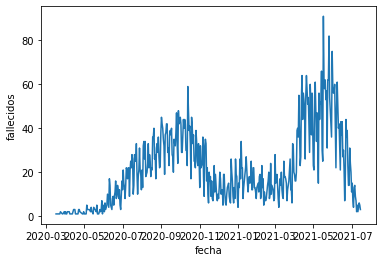

In [18]:
sns.lineplot(x="fecha", y="fallecidos", data=dfTemp2.toPandas())
plt.show()


Se puede ver en el gráfico las distintas "oleadas" de fallecidos. 

### Fecha diagnostico y fecha inicio de síntomas

creo una variable nueva con la diferencia en días entre las fechas, pensando que la distancia entre la fecha de síntomas y el diagnóstico (asumiendo que son la cantidad de días que tardó en ir al médico) puede tener una incidencia en el fallecimiento.

In [19]:
from pyspark.sql.functions import datediff, to_date, lit

dfcovid=dfcovid.withColumn("dias_diagnostico", 
              datediff("fecha_diagnostico",
                       "fecha_inicio_sintomas"))



In [20]:
dfcovid.groupBy('dias_diagnostico').count().orderBy('count').show()

+----------------+-----+
|dias_diagnostico|count|
+----------------+-----+
|            -228|    1|
|             372|    1|
|             264|    1|
|             413|    1|
|             247|    1|
|             323|    1|
|            -201|    1|
|            -140|    1|
|            -243|    1|
|             330|    1|
|            -200|    1|
|            -275|    1|
|             210|    1|
|            -199|    1|
|            -165|    1|
|            -249|    1|
|            -170|    1|
|            -103|    1|
|             -66|    1|
|            -143|    1|
+----------------+-----+
only showing top 20 rows



In [21]:
from  pyspark.sql.functions import abs
#sustituyo con el valor absoluto (habia valores en negativo)
dfcovid = dfcovid.withColumn('dias_diagnostico',abs(dfcovid.dias_diagnostico))
#dfcovid.show()

#dfcovid=dfcovid.withColumn('dias_diagnostico', dfcovid.dias_diagnostico.abs())



In [22]:
#a los valores mayores a 100 les asigno null
dfcovid = dfcovid.withColumn('dias_diagnostico',
                             F.when(dfcovid.dias_diagnostico >=100,None)
                             .otherwise(dfcovid.dias_diagnostico))
dfcovid.show(2)



+--------------+----+----+---------------------+-------------------+-------------------+-------------+---------------------+-----------------------+--------------------------+-------------------+-----------------+---------+---------------+------+----------------+
|id_evento_caso|sexo|edad|fecha_inicio_sintomas|     fecha_apertura|  fecha_diagnostico|sepi_apertura|origen_financiamiento|residencia_provincia_id|residencia_departamento_id|  fecha_internacion|cuidado_intensivo|fallecido|pais_nacimiento|genero|dias_diagnostico|
+--------------+----+----+---------------------+-------------------+-------------------+-------------+---------------------+-----------------------+--------------------------+-------------------+-----------------+---------+---------------+------+----------------+
|        740861|   F|  75|  2020-03-02 00:00:00|2020-03-07 00:00:00|2020-03-09 00:00:00|           10|              Público|                     22|                       140|               null|             

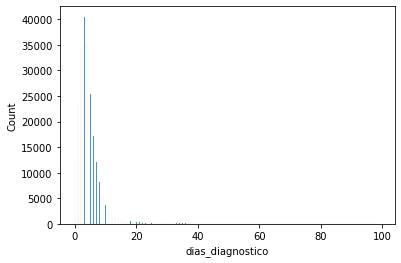

In [23]:
sns.histplot(x="dias_diagnostico", data=dfcovid.toPandas())
plt.show()

Se ve en el histograma que en la mayor parte de los casos la cantidad de días es de XXX.
Hay valores muy altos que pueden ser erroneos. En este caso se conservan pero podrían eliminarse

### SEPI
Semana epidemiológica

In [24]:
dfcovid.groupBy('sepi_apertura').count().orderBy('count').show()

+-------------+-----+
|sepi_apertura|count|
+-------------+-----+
|           29| 2888|
|           50| 3465|
|           30| 3894|
|            7| 3976|
|           31| 4012|
|            9| 4223|
|           51| 4312|
|           52| 4342|
|            8| 4436|
|           49| 4542|
|           48| 4611|
|           10| 4773|
|            6| 4883|
|           33| 4916|
|           32| 5069|
|           34| 5126|
|           11| 5130|
|            5| 5171|
|           47| 5718|
|            4| 5898|
+-------------+-----+
only showing top 20 rows



In [25]:
dfTemp2= spark.sql("""
    Select sepi_apertura AS sepi, count(*) AS casos
    FROM dfcovid
    GROUP BY sepi_apertura
    ORDER BY sepi_apertura asc
    """)


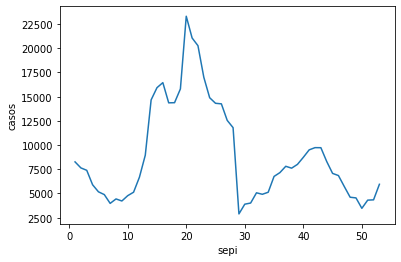

In [26]:
sns.lineplot(x="sepi", y="casos", data=dfTemp2.toPandas())
plt.show()

# Tipo de financiamiento

lo transformo en una variable dummy (0,1)


In [27]:
dfcovid.groupBy('origen_financiamiento').count().orderBy('count').show()

+---------------------+------+
|origen_financiamiento| count|
+---------------------+------+
|              Privado|136449|
|              Público|338123|
+---------------------+------+



In [28]:
dfcovid=dfcovid.withColumn("financiamiento", 
    F.when((F.col("origen_financiamiento") == 'Privado'), 0)\
    .when((F.col("origen_financiamiento") == 'Público'), 1)\
    .otherwise(0)
)


In [29]:
dfcovid.groupBy('financiamiento').count().orderBy('count').show()

+--------------+------+
|financiamiento| count|
+--------------+------+
|             0|136449|
|             1|338123|
+--------------+------+



### variables de domicilio

Las siguientes variables pueden servir para identificar el lugar de residencia
residencia_provincia_id: integer (nullable = true)
residencia_departamento_id: integer (nullable = true)

Para este ejercicio no se usarán. Tal vez podrían transformarse en variables dummy por provincia. 

## Creo una variable migrante=si/no

In [30]:

#1 creo una columna que marque migrante/no migrante
dfcovid=dfcovid.withColumn("migrante", 
    F.when((F.col("pais_nacimiento") == 'Argentina'), 0)\
    .when((F.col("pais_nacimiento") == '*sin dato*'), 0)\
    .when((F.col("pais_nacimiento") == ' '), 0)\
    .otherwise(1)
)


In [31]:
dfcovid.show(5)

+--------------+----+----+---------------------+-------------------+-------------------+-------------+---------------------+-----------------------+--------------------------+-------------------+-----------------+---------+---------------+------+----------------+--------------+--------+
|id_evento_caso|sexo|edad|fecha_inicio_sintomas|     fecha_apertura|  fecha_diagnostico|sepi_apertura|origen_financiamiento|residencia_provincia_id|residencia_departamento_id|  fecha_internacion|cuidado_intensivo|fallecido|pais_nacimiento|genero|dias_diagnostico|financiamiento|migrante|
+--------------+----+----+---------------------+-------------------+-------------------+-------------+---------------------+-----------------------+--------------------------+-------------------+-----------------+---------+---------------+------+----------------+--------------+--------+
|        740861|   F|  75|  2020-03-02 00:00:00|2020-03-07 00:00:00|2020-03-09 00:00:00|           10|              Público|            

In [32]:
dfcovid.groupBy('migrante').count().orderBy('count').show()

+--------+------+
|migrante| count|
+--------+------+
|       0|158587|
|       1|315985|
+--------+------+




### Fallecidos
Es la variable que se quiere poder clasificar.
Las variables fecha de internación y cuidado_intensivo no se utilizan ya que están directamente vinculadas con el fallecimiento.

In [33]:
dfcovid.groupBy('fallecido').count().orderBy('count').show()

+---------+------+
|fallecido| count|
+---------+------+
|       SI| 10218|
|       NO|464354|
+---------+------+



Creo una variable fallecido 1/0 para usar en la clasificación

In [34]:
dfcovid=dfcovid.withColumn("fallecido_c", 
    F.when((F.col("fallecido") == 'NO'), 0)\
    .when((F.col("fallecido") == 'SI'), 1)\
    .otherwise(0)
)

In [35]:
dfcovid.groupBy('fallecido_c').count().orderBy('count').show()

+-----------+------+
|fallecido_c| count|
+-----------+------+
|          1| 10218|
|          0|464354|
+-----------+------+



In [36]:
dfcovid.printSchema()

root
 |-- id_evento_caso: integer (nullable = true)
 |-- sexo: string (nullable = true)
 |-- edad: integer (nullable = true)
 |-- fecha_inicio_sintomas: timestamp (nullable = true)
 |-- fecha_apertura: timestamp (nullable = true)
 |-- fecha_diagnostico: timestamp (nullable = true)
 |-- sepi_apertura: integer (nullable = true)
 |-- origen_financiamiento: string (nullable = true)
 |-- residencia_provincia_id: integer (nullable = true)
 |-- residencia_departamento_id: integer (nullable = true)
 |-- fecha_internacion: timestamp (nullable = true)
 |-- cuidado_intensivo: string (nullable = true)
 |-- fallecido: string (nullable = true)
 |-- pais_nacimiento: string (nullable = true)
 |-- genero: integer (nullable = true)
 |-- dias_diagnostico: integer (nullable = true)
 |-- financiamiento: integer (nullable = false)
 |-- migrante: integer (nullable = false)
 |-- fallecido_c: integer (nullable = false)



In [37]:
dfcovid_clasif=dfcovid.select("genero","edad","dias_diagnostico",
                              "sepi_apertura",
                              "financiamiento","migrante","fallecido_c")

In [38]:
dfcovid_clasif.printSchema()

root
 |-- genero: integer (nullable = true)
 |-- edad: integer (nullable = true)
 |-- dias_diagnostico: integer (nullable = true)
 |-- sepi_apertura: integer (nullable = true)
 |-- financiamiento: integer (nullable = false)
 |-- migrante: integer (nullable = false)
 |-- fallecido_c: integer (nullable = false)



In [39]:
dfcovid_clasif.show(5)

+------+----+----------------+-------------+--------------+--------+-----------+
|genero|edad|dias_diagnostico|sepi_apertura|financiamiento|migrante|fallecido_c|
+------+----+----------------+-------------+--------------+--------+-----------+
|     1|  75|               7|           10|             1|       0|          0|
|     0|  67|               3|           11|             0|       0|          0|
|     0|  25|               8|           11|             0|       0|          0|
|     1|  21|              10|           11|             0|       0|          0|
|     1|  29|               4|           12|             0|       0|          0|
+------+----+----------------+-------------+--------------+--------+-----------+
only showing top 5 rows



se corrigen y completan los datos con valores nulos para que no de error el clasificador

In [40]:
def _get_typed_cols(df, col_type='cat'):
    assert col_type in ('cat', 'num')
    dtypes = ('int', 'double') if col_type == 'num' else ('string')
    typed_cols = [c for c,dtype in df.dtypes if dtype.startswith(dtypes) 
                  and c not in PROTECTED_COLS]
    return typed_cols

In [41]:
def _fill_nulls(df):
    for t in ['num', 'cat']:
        cols = _get_typed_cols(df, col_type=t)
        for c in cols:
            if t == 'num':
                median_val = df.approxQuantile(c, [0.5], 0)[0]
                df = df.fillna(median_val, subset=[c])
            else:
                val_counts = df.filter(f.col(c).isNotNull()).select(c).groupBy(c).count().orderBy(f.desc('count'))
                common_val = val_counts.select(c).first()[0]
                df = df.fillna(common_val, subset=[c])
    return df

In [42]:
##se llenan los vacios con media para evitar que de error

PROTECTED_COLS = ['fallecido_c']
dfcovid_clasif = _fill_nulls(dfcovid_clasif)

Guardo los datos en formato parquet para que queden las variables que transformé.

In [43]:
#dfcovid_clasif.write.parquet("/dataset/parquetv4/covid_clasif2.parquet") 

   # Pruebas de clasificación con distintas técnicas
   
   En esta sección se van a aplicar distintas técnicas de clasificación.
   En primer lugar se preparar los datos y se separa en 

In [113]:
### en caso que se retome desde aqui se puede levantar directamente el parquet

In [3]:
dfclasif=spark.read.parquet("/dataset/parquetv4/covid_clasif2.parquet") 

#dfclasif=dfcovid_clasif


In [4]:
dfclasif.show()

+------+----+----------------+-------------+--------------+--------+-----------+
|genero|edad|dias_diagnostico|sepi_apertura|financiamiento|migrante|fallecido_c|
+------+----+----------------+-------------+--------------+--------+-----------+
|     1|  75|               7|           10|             1|       0|          0|
|     0|  67|               3|           11|             0|       0|          0|
|     0|  25|               8|           11|             0|       0|          0|
|     1|  21|              10|           11|             0|       0|          0|
|     1|  29|               4|           12|             0|       0|          0|
|     1|  24|               5|           12|             0|       0|          0|
|     0|  37|               5|           12|             1|       0|          0|
|     0|  29|               4|           12|             1|       0|          0|
|     0|  78|               6|           12|             0|       0|          0|
|     0|  34|               

### regresion logistica

En esta primera parte se realiza una regresion logística, para ello se preparara el vector de features y el "label"

In [5]:
# Armar columna de features
from pyspark.ml.feature import VectorAssembler


assembler = VectorAssembler(inputCols=['genero','edad','dias_diagnostico','sepi_apertura','financiamiento','migrante'],
    outputCol="features")
dfclasif = assembler.transform(dfclasif)
#dfcovid_clasif.select(['features']).toPandas().head(5)





In [6]:
dfclasif.show(5)

+------+----+----------------+-------------+--------------+--------+-----------+--------------------+
|genero|edad|dias_diagnostico|sepi_apertura|financiamiento|migrante|fallecido_c|            features|
+------+----+----------------+-------------+--------------+--------+-----------+--------------------+
|     1|  75|               7|           10|             1|       0|          0|[1.0,75.0,7.0,10....|
|     0|  67|               3|           11|             0|       0|          0|[0.0,67.0,3.0,11....|
|     0|  25|               8|           11|             0|       0|          0|[0.0,25.0,8.0,11....|
|     1|  21|              10|           11|             0|       0|          0|[1.0,21.0,10.0,11...|
|     1|  29|               4|           12|             0|       0|          0|[1.0,29.0,4.0,12....|
+------+----+----------------+-------------+--------------+--------+-----------+--------------------+
only showing top 5 rows



In [13]:
dfclasif.select('features').show()

+--------------------+
|            features|
+--------------------+
|[1.0,75.0,7.0,10....|
|[0.0,67.0,3.0,11....|
|[0.0,25.0,8.0,11....|
|[1.0,21.0,10.0,11...|
|[1.0,29.0,4.0,12....|
|[1.0,24.0,5.0,12....|
|[0.0,37.0,5.0,12....|
|[0.0,29.0,4.0,12....|
|[0.0,78.0,6.0,12....|
|[0.0,34.0,6.0,12....|
|[1.0,4.0,5.0,12.0...|
|[0.0,58.0,4.0,12....|
|[1.0,57.0,6.0,12....|
|[0.0,35.0,5.0,12....|
|[1.0,29.0,5.0,12....|
|[0.0,53.0,4.0,12....|
|[0.0,55.0,5.0,12....|
|[0.0,36.0,9.0,12....|
|[0.0,22.0,13.0,12...|
|[0.0,60.0,9.0,12....|
+--------------------+
only showing top 20 rows



In [7]:
##creo el conjunto de entrenamiento y el de test

# Train/test split
train_df, test_df = dfclasif.randomSplit([0.7,0.3],seed=7147)

In [8]:
train_df.count()

331661

In [9]:
test_df.count()

142911

In [10]:
from pyspark.ml.classification import LogisticRegression
#entreno mi modelo
lr = LogisticRegression(labelCol='fallecido_c', featuresCol='features')
lrm = lr.fit(train_df)

In [11]:
# Print the coefficients and intercepts for logistic regression 
print(" coefficients: " + str(lrm.coefficientMatrix))
print(" intercepts: " + str(lrm.interceptVector))

 coefficients: DenseMatrix([[-0.62390962,  0.09824104,  0.02571754, -0.00963301, -0.15260109,
              -0.45848769]])
 intercepts: [-8.438826472773119]


In [12]:
# Metricas de evaluacion (insample)

print(" accuracy: " + str(lrm.summary.accuracy))
print(" areaUnderROC: " + str(lrm.summary.areaUnderROC))


 accuracy: 0.9781342997820063
 areaUnderROC: 0.9128839575129182


Se obtiene un buen performance del clasificador:

 accuracy: 0.9781342997820063
 areaUnderROC: 0.9128839575129182
 
 

In [17]:
falsePositiveRate = lrm.summary.weightedFalsePositiveRate
truePositiveRate = lrm.summary.weightedTruePositiveRate
fMeasure = lrm.summary.weightedFMeasure()
precision = lrm.summary.weightedPrecision
recall = lrm.summary.weightedRecall
print("False Positive Rate: %s\nTrue Positive Rate: %s\nF-measure: %s\nPrecision: %s\nRecall: %s"
      % (falsePositiveRate, truePositiveRate, fMeasure, precision, recall))

False Positive Rate: 0.9415708544093597
True Positive Rate: 0.9781342997820064
F-measure: 0.9690450047786354
Precision: 0.9674155211801008
Recall: 0.9781342997820064


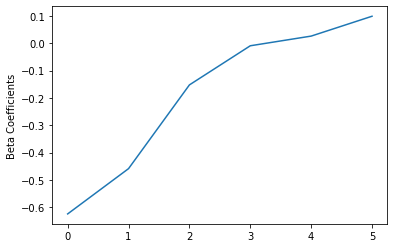

In [21]:
import matplotlib.pyplot as plt
import numpy as np
beta = np.sort(lrm.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

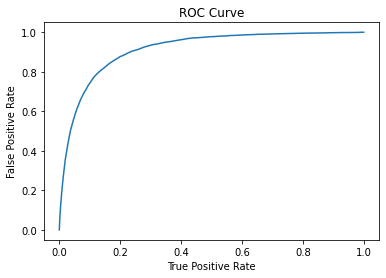

Training set areaUnderROC: 0.9128839575129182


In [22]:
trainingSummary = lrm.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

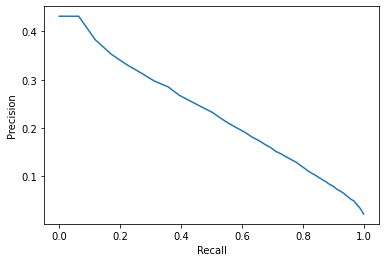

In [23]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [19]:
pred_df = lrm.transform(test_df)
pred_df.show(2)

+------+----+----------------+-------------+--------------+--------+-----------+--------------------+--------------------+--------------------+----------+
|genero|edad|dias_diagnostico|sepi_apertura|financiamiento|migrante|fallecido_c|            features|       rawPrediction|         probability|prediction|
+------+----+----------------+-------------+--------------+--------+-----------+--------------------+--------------------+--------------------+----------+
|     0|   1|               0|            3|             1|       1|          0|[0.0,1.0,0.0,3.0,...|[8.98057324055922...|[0.99987418513580...|       0.0|
|     0|   1|               0|           19|             0|       1|          0|[0.0,1.0,0.0,19.0...|[8.98210027443458...|[0.99987437708863...|       0.0|
|     0|   1|               0|           19|             1|       1|          0|[0.0,1.0,0.0,19.0...|[9.13470136914081...|[0.99989215431774...|       0.0|
|     0|   1|               0|           26|             1|       1|  

In [48]:
pred_df.groupBy('fallecido_c', 'prediction').count().show()

+-----------+----------+------+
|fallecido_c|prediction| count|
+-----------+----------+------+
|          1|       1.0|   117|
|          0|       0.0|139719|
|          1|       0.0|  2927|
|          0|       1.0|   148|
+-----------+----------+------+



Se puede ver que a pesar de que da un buen performance, solo puede clasificar 117 fallecidos correctamente. Los grupos estan muy desblanaceados y además no son variable suficientemente explicativas para poder predecir el fallecimiento.

In [20]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator(labelCol='fallecido_c')
evaluator.evaluate(pred_df)

0.9105660784633718

## Decision Tree Classifier

In [26]:
from pyspark.ml.classification import DecisionTreeClassifier
dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'fallecido_c')
dtModel = dt.fit(train_df)


In [27]:
predictions = dtModel.transform(test_df)
#predictions.show(10)

+------+----+----------------+-------------+--------------+--------+-----------+--------------------+-----------------+--------------------+----------+
|genero|edad|dias_diagnostico|sepi_apertura|financiamiento|migrante|fallecido_c|            features|    rawPrediction|         probability|prediction|
+------+----+----------------+-------------+--------------+--------+-----------+--------------------+-----------------+--------------------+----------+
|     0|   1|               0|            3|             1|       1|          0|[0.0,1.0,0.0,3.0,...|[307454.0,3101.0]|[0.99001465118900...|       0.0|
|     0|   1|               0|           19|             0|       1|          0|[0.0,1.0,0.0,19.0...|[307454.0,3101.0]|[0.99001465118900...|       0.0|
|     0|   1|               0|           19|             1|       1|          0|[0.0,1.0,0.0,19.0...|[307454.0,3101.0]|[0.99001465118900...|       0.0|
|     0|   1|               0|           26|             1|       1|          0|[0.0,1.0

In [30]:
# Select example rows to display.
predictions.select("prediction","probability","fallecido_c", "features").show(5)



+----------+--------------------+-----------+--------------------+
|prediction|         probability|fallecido_c|            features|
+----------+--------------------+-----------+--------------------+
|       0.0|[0.99001465118900...|          0|[0.0,1.0,0.0,3.0,...|
|       0.0|[0.99001465118900...|          0|[0.0,1.0,0.0,19.0...|
|       0.0|[0.99001465118900...|          0|[0.0,1.0,0.0,19.0...|
|       0.0|[0.99001465118900...|          0|[0.0,1.0,0.0,26.0...|
|       0.0|[0.99001465118900...|          0|(6,[1,3],[1.0,45.0])|
+----------+--------------------+-----------+--------------------+
only showing top 5 rows



In [33]:
predictions.select("prediction","probability","fallecido_c", "features").filter('fallecido_c = 1').show()

+----------+--------------------+-----------+--------------------+
|prediction|         probability|fallecido_c|            features|
+----------+--------------------+-----------+--------------------+
|       0.0|[0.99001465118900...|          1|[0.0,14.0,2.0,22....|
|       0.0|[0.99001465118900...|          1|[0.0,15.0,4.0,23....|
|       0.0|[0.99001465118900...|          1|[0.0,15.0,5.0,53....|
|       0.0|[0.99001465118900...|          1|[0.0,19.0,4.0,14....|
|       0.0|[0.99001465118900...|          1|[0.0,24.0,1.0,15....|
|       0.0|[0.99001465118900...|          1|[0.0,24.0,3.0,42....|
|       0.0|[0.99001465118900...|          1|[0.0,27.0,4.0,38....|
|       0.0|[0.99001465118900...|          1|[0.0,29.0,4.0,21....|
|       0.0|[0.99001465118900...|          1|[0.0,30.0,0.0,43....|
|       0.0|[0.99001465118900...|          1|[0.0,30.0,0.0,50....|
|       0.0|[0.99001465118900...|          1|[0.0,30.0,2.0,44....|
|       0.0|[0.99001465118900...|          1|[0.0,31.0,0.0,18.

Como se puede ver, en el siguiente cuador solo clasifica bien 156 casos de fallecidos mientras que 2888 fallecidos no los clasifica correctamente.

Los grupos estan muy desbalanceados y además las variables no son suficientes para clasificar estos datos. (claramente)

In [36]:
predictions.groupBy('fallecido_c', 'prediction').count().show()

+-----------+----------+------+
|fallecido_c|prediction| count|
+-----------+----------+------+
|          1|       1.0|   156|
|          0|       0.0|139700|
|          1|       0.0|  2888|
|          0|       1.0|   167|
+-----------+----------+------+



In [47]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator(labelCol='fallecido_c')

evaluator.evaluate(predictions)
# summary only
#print(dtModel)



0.24184009984067176

In [ ]:
spark.stop()